## installation

In [1]:
# !pip install ultralytics

## imports

In [ ]:
import os
import requests
from io import BytesIO
from PIL import Image
import zipfile
import json
import tarfile
import numpy as np
from dataclasses import dataclass, field
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import glob
import cv2
import random
import time
from shutil import copyfile

## Data Transformation

In [ ]:
DATA_DIR = "/content/drive/MyDrive/horse10"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)

In [ ]:
import os
import json
from shutil import copyfile
def copy_images_from_json(input_file, output_path):
    with open(input_file, 'r') as file:
        json_data = json.load(file)
    for data in json_data['images']:
        img_file = data["file_name"]
        filename = str(data['id']) + '.png'
        copyfile(os.path.join('/content/drive/MyDrive/horse10/', img_file),
                 os.path.join(output_path, filename))

In [ ]:
# input_file_path = '/content/drive/MyDrive/horse10/annotations/horse10-train-split3.json'
# output_directory_path = '/content/drive/MyDrive/horse10/train/images'
# copy_images_from_json(input_file_path, output_directory_path)

In [ ]:
# input_file_path = '/content/drive/MyDrive/horse10/annotations/horse10-test-split3.json'
# output_directory_path = '/content/drive/MyDrive/horse10/valid/images'
# copy_images_from_json(input_file_path, output_directory_path)

In [ ]:
# with open(input_file_path, 'r') as file:
#         json_data = json.load(file)

In [ ]:
for img_data,annotation_data in  zip(json_data['images'],json_data['annotations']):
  print(img_data.keys())
  print(annotation_data['keypoints'])
  break

dict_keys(['id', 'file_name', 'height', 'width'])
[3.0, 87.3, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
CLASS_ID = 0
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.


    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    l=len(norm_kps_per_img)
    i=1
    while i<=l:
      norm_kps_per_img[i-1]=norm_kps_per_img[i-1]/IMG_W
      norm_kps_per_img[i]=norm_kps_per_img[i]/IMG_H
      i=i+3

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [ ]:
def create_yolo_txt_files(json_file, LABEL_PATH):
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    for img_data,annotation_data in  zip(json_data['images'],json_data['annotations']):




        IMAGE_ID = img_data["id"]

        IMG_WIDTH, IMG_HEIGHT = img_data["width"], img_data["height"]

        landmark_kpts  = np.nan_to_num(np.array(annotation_data["keypoints"], dtype=np.float32))
        landmarks_bboxes = np.array(annotation_data["bbox"], dtype=np.float32)
        if len(landmark_kpts)!=66:
          print("false")
        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = str(IMAGE_ID)+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [ ]:
# input_file_path = '/content/drive/MyDrive/horse10/annotations/horse10-train-split3.json'
# create_yolo_txt_files(input_file_path, TRAIN_LABEL_PATH)

In [ ]:
# input_file_path = '/content/drive/MyDrive/horse10/annotations/horse10-test-split3.json'
# create_yolo_txt_files(input_file_path, VALID_LABEL_PATH)

## Model

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "horse-keypoints.yaml"
    MODEL:          str = "yolov8s-pose.pt"
    EPOCHS:         int = 50
    KPT_SHAPE:    tuple = (22,3)
    PROJECT:        str = "Horse_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "horse"})

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    BATCH_SIZE:    int   = 32
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0

In [ ]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [ ]:
current_dir = os.getcwd()

data_dict = dict(
                path      = DATA_DIR,
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

In [ ]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(data    = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR
           )

100%|██████████| 22.4M/22.4M [00:00<00:00, 205MB/s]


Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=horse-keypoints.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Horse_Keypoints, name=yolov8s-pose_50_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[22, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1 

100%|██████████| 6.23M/6.23M [00:00<00:00, 114MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1d9fVKFxu7VuCoVFZafnwSBkWzrkn2_ap/horse10/train/labels... 1386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1386/1386 [10:30<00:00,  2.20it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1d9fVKFxu7VuCoVFZafnwSBkWzrkn2_ap/horse10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/1d9fVKFxu7VuCoVFZafnwSBkWzrkn2_ap/horse10/valid/labels.cache... 4046 images, 2682 backgrounds, 0 corrupt: 100%|██████████| 6728/6728 [00:00<?, ?it/s]


Plotting labels to Horse_Keypoints/yolov8s-pose_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to Horse_Keypoints/yolov8s-pose_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.28G       1.39      9.654     0.6761      1.581      1.635         20        640: 100%|██████████| 44/44 [04:16<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:32<00:00,  1.15it/s]


                   all       6728       4046      0.453      0.823      0.463      0.295    0.00067    0.00593   0.000115   7.75e-05

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.44G     0.8862      7.298     0.5578     0.6477       1.15         14        640: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.317      0.618       0.31      0.102   0.000432     0.0104   0.000219   0.000127

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.24G     0.9023      6.128     0.5173     0.6603      1.143         11        640: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.222      0.762       0.23      0.129     0.0456      0.162    0.00883    0.00115

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.42G      0.927      5.906     0.4915     0.6942      1.173         16        640: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.283      0.397      0.164     0.0883      0.145      0.203     0.0354    0.00454

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.92G     0.8655      5.512      0.459     0.6141      1.125         15        640: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]


                   all       6728       4046      0.443      0.745      0.535      0.357      0.298      0.352      0.139     0.0248

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.37G     0.8127      5.103     0.4209     0.5992      1.103         14        640: 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.20it/s]


                   all       6728       4046      0.569      0.719      0.499      0.383      0.459      0.531      0.285     0.0535

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.32G     0.7948      5.005     0.3862     0.5828      1.088         17        640: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.22it/s]


                   all       6728       4046      0.542      0.816      0.533      0.403      0.454      0.645      0.323     0.0664

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.29G     0.7694      4.846      0.363     0.5654      1.077         14        640: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.21it/s]


                   all       6728       4046      0.544      0.745      0.484       0.35      0.457      0.553      0.288     0.0558

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/50       8.3G       0.75      4.721     0.3431     0.5507      1.062         17        640: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]


                   all       6728       4046      0.568      0.763      0.566      0.459      0.507      0.645      0.428     0.0924

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.27G     0.6942      4.492     0.3417     0.5191      1.038         16        640: 100%|██████████| 44/44 [00:34<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.22it/s]


                   all       6728       4046      0.578      0.879      0.553      0.437      0.504      0.688      0.388      0.084

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.26G     0.6811      4.426     0.3315     0.4919      1.024         11        640: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.585      0.854      0.583      0.499      0.498      0.677      0.422     0.0843

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.35G     0.6248      4.137       0.32     0.4622     0.9924         15        640: 100%|██████████| 44/44 [00:34<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.25it/s]


                   all       6728       4046      0.595      0.883       0.61      0.514      0.551      0.784      0.529      0.157

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.23G     0.6243      4.115     0.3154     0.4674     0.9956         16        640: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.23it/s]


                   all       6728       4046      0.579       0.87       0.58       0.49      0.535       0.75      0.467      0.146

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.25G     0.6048      3.952     0.3086     0.4539     0.9899         13        640: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:29<00:00,  1.19it/s]


                   all       6728       4046      0.588      0.864      0.561      0.467      0.489      0.666      0.371     0.0881

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.35G     0.5996      3.835     0.3042     0.4421     0.9841         14        640: 100%|██████████| 44/44 [00:35<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.22it/s]


                   all       6728       4046      0.558      0.869      0.558       0.44      0.517       0.78      0.465      0.145

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.24G      0.596      3.726     0.2936     0.4534     0.9818         12        640: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]


                   all       6728       4046      0.576      0.818      0.541      0.456      0.522      0.727      0.442      0.148

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.34G     0.5935      3.759     0.2899     0.4442     0.9814         16        640: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]

                   all       6728       4046      0.573      0.858      0.611      0.518      0.526      0.724      0.505      0.146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.23G     0.5792      3.561     0.2764     0.4367     0.9699         11        640: 100%|██████████| 44/44 [00:35<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.587      0.871      0.563      0.477      0.559      0.818      0.501      0.181

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.22G     0.5708      3.446     0.2833     0.4263     0.9662         20        640: 100%|██████████| 44/44 [00:36<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:28<00:00,  1.20it/s]


                   all       6728       4046      0.587      0.889      0.577      0.485      0.561      0.824      0.516      0.181

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.22G     0.5499      3.512     0.2771     0.4059     0.9619         19        640: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.21it/s]


                   all       6728       4046      0.586      0.864      0.621      0.552      0.568      0.826      0.574      0.214

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.22G     0.5426      3.435      0.264     0.4049       0.96         22        640: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]


                   all       6728       4046      0.581      0.876      0.648      0.538      0.561      0.813      0.596      0.231

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.22G     0.5349      3.354     0.2644     0.4057     0.9601         12        640: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:28<00:00,  1.20it/s]


                   all       6728       4046      0.584      0.868      0.601      0.516      0.563      0.806      0.547      0.223

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.23G       0.52      3.145     0.2494     0.3905     0.9481         17        640: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.21it/s]


                   all       6728       4046      0.585      0.858      0.559      0.468      0.563      0.817      0.498      0.207

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.24G     0.5231      3.117     0.2522     0.3981      0.953         16        640: 100%|██████████| 44/44 [00:33<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.24it/s]


                   all       6728       4046      0.586      0.876      0.605      0.523      0.562      0.819      0.548      0.259

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.33G     0.5028       2.85     0.2424     0.3646     0.9376         12        640: 100%|██████████| 44/44 [00:36<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:24<00:00,  1.26it/s]


                   all       6728       4046      0.584      0.886       0.61      0.538       0.57      0.824      0.562      0.271

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.22G     0.4982      2.745     0.2454     0.3734     0.9364         17        640: 100%|██████████| 44/44 [00:33<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:24<00:00,  1.25it/s]

                   all       6728       4046      0.588      0.871      0.573      0.507      0.584      0.834      0.539      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.22G     0.4852      2.616     0.2386     0.3634     0.9372         11        640: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:24<00:00,  1.25it/s]


                   all       6728       4046      0.585        0.9      0.619      0.547      0.581      0.838      0.578      0.279

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.22G     0.4872      2.546     0.2406      0.366     0.9291         16        640: 100%|██████████| 44/44 [00:34<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.27it/s]


                   all       6728       4046      0.588      0.897      0.628      0.553      0.575      0.836       0.57      0.245

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.22G     0.4827      2.524      0.239     0.3615     0.9328         20        640: 100%|██████████| 44/44 [00:35<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.25it/s]

                   all       6728       4046      0.589      0.892      0.583       0.52      0.575      0.837      0.537      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.22G     0.4775      2.466     0.2399     0.3551     0.9223         14        640: 100%|██████████| 44/44 [00:34<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:26<00:00,  1.22it/s]


                   all       6728       4046      0.589       0.88      0.606      0.538      0.575      0.839      0.564        0.3

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.22G     0.4781      2.373     0.2302     0.3523     0.9246         14        640: 100%|██████████| 44/44 [00:32<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:25<00:00,  1.23it/s]

                   all       6728       4046      0.591      0.909      0.675      0.609      0.584      0.847      0.642      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.22G     0.4675       2.35     0.2335     0.3465     0.9169         13        640: 100%|██████████| 44/44 [00:34<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.26it/s]


                   all       6728       4046      0.598      0.873       0.67      0.602      0.583      0.842      0.633      0.354

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.22G     0.4446      2.282     0.2291     0.3346     0.9149         16        640: 100%|██████████| 44/44 [00:34<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.26it/s]


                   all       6728       4046      0.587      0.872      0.594       0.53      0.578      0.851      0.565      0.316

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.22G      0.447      2.155     0.2295     0.3409     0.9163         13        640: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.27it/s]

                   all       6728       4046      0.579       0.89      0.588      0.513      0.571      0.841       0.55      0.308



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.22G     0.4399      2.186     0.2243     0.3378     0.9143         17        640: 100%|██████████| 44/44 [00:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:24<00:00,  1.26it/s]


                   all       6728       4046      0.584      0.894      0.573      0.513      0.583      0.838      0.538      0.328

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.22G     0.4288      2.036     0.2179     0.3247     0.9065         16        640: 100%|██████████| 44/44 [00:34<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.20it/s]

                   all       6728       4046      0.579      0.895      0.617      0.551      0.573      0.844       0.58      0.366



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.22G     0.4255       2.05      0.223     0.3199     0.9126         21        640: 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]


                   all       6728       4046      0.586      0.887      0.601      0.539      0.575      0.842      0.569      0.333

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.22G     0.4127        1.9     0.2329      0.312     0.9011         18        640: 100%|██████████| 44/44 [00:33<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]


                   all       6728       4046      0.585      0.892      0.623      0.549      0.583      0.856      0.594      0.381

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.22G     0.4259      1.776     0.2345     0.3104      0.904         10        640: 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.27it/s]


                   all       6728       4046      0.587      0.887      0.584      0.523      0.572      0.848      0.547      0.364

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.22G     0.4045      1.604     0.2254     0.3083     0.8956         18        640: 100%|██████████| 44/44 [00:33<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:28<00:00,  1.20it/s]

                   all       6728       4046      0.587      0.887      0.581      0.518      0.576      0.841      0.544      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.22G     0.3403      1.037     0.1677     0.2529     0.8597         10        640: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]

                   all       6728       4046      0.587      0.879      0.579      0.513      0.573      0.848      0.545      0.392



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.22G     0.3273     0.9632     0.1717     0.2465      0.862         10        640: 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.27it/s]


                   all       6728       4046      0.586      0.883      0.613       0.55      0.573      0.855      0.578      0.424

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.22G     0.3246     0.9073     0.1644     0.2385     0.8599         10        640: 100%|██████████| 44/44 [00:32<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.27it/s]

                   all       6728       4046      0.586      0.888        0.6      0.539      0.582      0.853      0.573      0.419



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.22G     0.3206     0.8764     0.1687     0.2385      0.851         10        640: 100%|██████████| 44/44 [00:33<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]


                   all       6728       4046      0.588      0.891      0.627      0.573      0.578      0.868      0.605      0.452

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.22G     0.3082     0.8269     0.1607     0.2303     0.8418         10        640: 100%|██████████| 44/44 [00:33<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]

                   all       6728       4046       0.59       0.89       0.59       0.54      0.585      0.862      0.567      0.448



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.32G     0.3005     0.7367     0.1652     0.2256     0.8454         10        640: 100%|██████████| 44/44 [00:32<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:23<00:00,  1.28it/s]

                   all       6728       4046      0.588      0.899      0.601       0.55      0.581      0.868      0.579      0.452



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.22G     0.2951     0.7059     0.1612      0.223     0.8511          9        640: 100%|██████████| 44/44 [00:32<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]


                   all       6728       4046       0.59      0.893      0.573      0.521      0.583      0.871      0.551      0.442

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.22G     0.2872     0.7019     0.1561     0.2175     0.8498         10        640: 100%|██████████| 44/44 [00:33<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]

                   all       6728       4046      0.587      0.891      0.587      0.539      0.583      0.866      0.568      0.458



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.22G     0.2749     0.6611     0.1589     0.2083     0.8399          8        640: 100%|██████████| 44/44 [00:32<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]


                   all       6728       4046      0.584      0.896      0.577      0.529       0.58      0.868      0.557      0.454

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.21G     0.2735      0.625     0.1582     0.2027     0.8364         10        640: 100%|██████████| 44/44 [00:32<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:22<00:00,  1.28it/s]


                   all       6728       4046      0.588      0.888      0.581      0.531      0.582      0.866       0.56      0.455

50 epochs completed in 1.762 hours.
Optimizer stripped from Horse_Keypoints/yolov8s-pose_50_epochs/weights/last.pt, 23.8MB
Optimizer stripped from Horse_Keypoints/yolov8s-pose_50_epochs/weights/best.pt, 23.8MB

Validating Horse_Keypoints/yolov8s-pose_50_epochs/weights/best.pt...
Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-pose summary (fused): 187 layers, 11789469 parameters, 0 gradients, 30.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [01:27<00:00,  1.21it/s]


                   all       6728       4046      0.588      0.891      0.628      0.573      0.578      0.868      0.606      0.452
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to Horse_Keypoints/yolov8s-pose_50_epochs


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4415116590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

In [ ]:
ckpt_path  = os.path.join(train_config.PROJECT, train_config.NAME, "weights", "best.pt")
model_pose = YOLO(ckpt_path)

metrics = model_pose.val()

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-pose summary (fused): 187 layers, 11789469 parameters, 0 gradients, 30.9 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1d9fVKFxu7VuCoVFZafnwSBkWzrkn2_ap/horse10/valid/labels... 4046 images, 2682 backgrounds, 0 corrupt: 100%|██████████| 6728/6728 [29:54<00:00,  3.75it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1d9fVKFxu7VuCoVFZafnwSBkWzrkn2_ap/horse10/valid/labels.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 421/421 [01:31<00:00,  4.59it/s]


                   all       6728       4046      0.588      0.891      0.627      0.573      0.578      0.867      0.605      0.451
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/pose/val


## Inference

In [ ]:
colors = [(255, 0, 0),
          (0, 255, 0),
          (0, 0, 255),
          (255, 255, 0),
          (255, 0, 255),
          (0, 255, 255),
          (128, 0, 0),
          (0, 128, 0),
          (0, 0, 128),
          (128, 128, 0),
          (128, 0, 128),
          (0, 128, 128),
          (255, 128, 0),
          (255, 0, 128),
          (128, 255, 0),
          (0, 255, 128),
          (128, 0, 255),
          (0, 128, 255),
          (255, 128, 128),
          (128, 255, 128),
          (128, 128, 255),
          (255, 255, 255)]

In [ ]:
def draw_landmarks(image, landmarks):
    radius = 5
    if image.shape[1] > 1000:
        radius = 2

    color_index = 0
    for kpt_data in landmarks:
        # Assuming kpt_data directly contains the keypoints as [x, y, score,...]
        for j in range(0, len(kpt_data), 3):
            loc_x, loc_y = int(kpt_data[j]), int(kpt_data[j+1])
            color_id = colors[color_index % len(colors)]  # Cycle through colors safely

            # Only draw if the location values are not zero
            if loc_x and loc_y:
                cv2.circle(image, (loc_x, loc_y), radius, color=color_id, thickness=-1, lineType=cv2.LINE_AA)

            color_index += 1

    return image

In [ ]:
def draw_boxes_landmarks(image, detections, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, w, h = np.array(detections).astype("int").tolist()
    xmax= xmin+w
    ymax=ymin+h

    image=draw_landmarks(image, first_image_annotations)

    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)


    return image


image 1/1 /content/drive/MyDrive/horse10/valid/images/902.png: 384x640 1 horse, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/horse10/valid/images/1226.png: 384x640 1 horse, 18.0ms
Speed: 2.2ms preprocess, 18.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/horse10/valid/images/7133.png: 384x640 1 horse, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/horse10/valid/images/4797.png: 384x640 1 horse, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/horse10/valid/images/1558.png: 384x640 1 horse, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/drive/MyDrive/horse10/valid/images/2592.png: 384x64

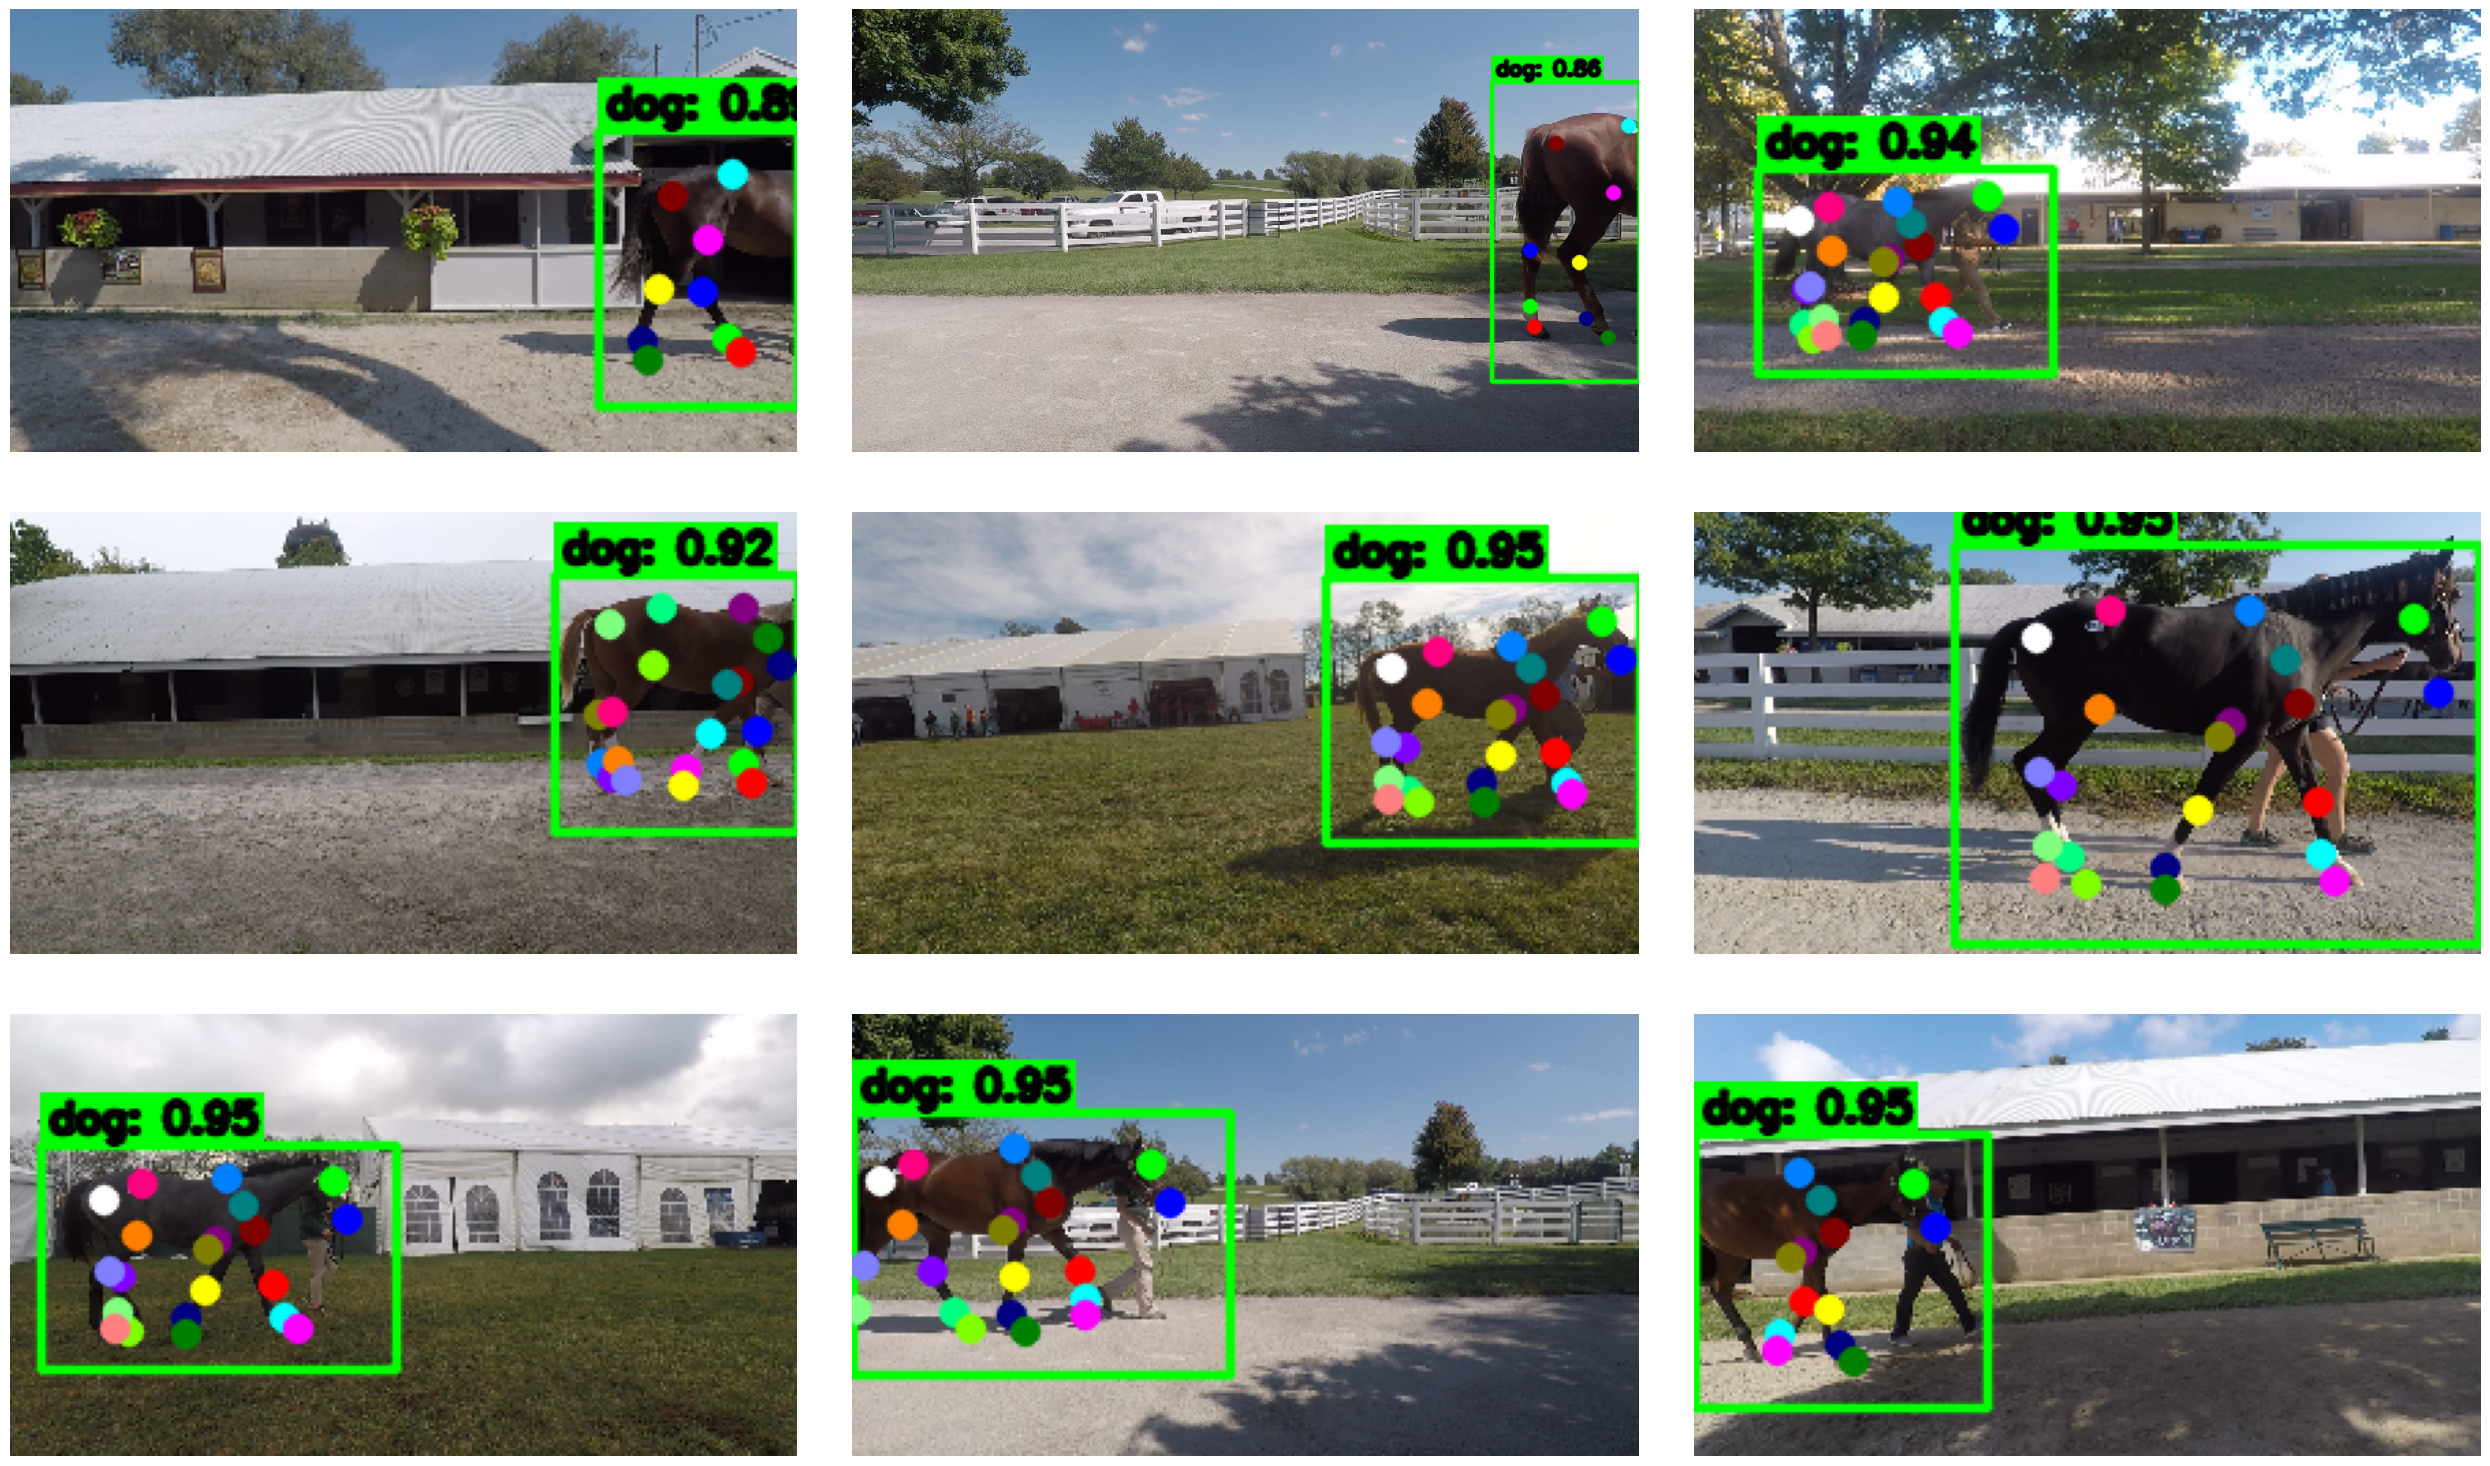

In [ ]:
VAL_IMAGE_FILES = os.listdir(VALID_IMG_PATH)
num_samples = 9
num_rows = 3
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(90)
random.shuffle(VAL_IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(VAL_IMAGE_FILES[:num_samples], ax.flat)):

    image_pred = prepare_predictions(VALID_IMG_PATH, file, model_pose)
    axis.imshow(image_pred[...,::-1])
    axis.axis("off")

plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();